In [92]:
import pandas as pd
import seaborn as sns
import numpy as np
import linearmodels as lm
import matplotlib
import math
import statsmodels.formula.api as smf
import statsmodels.api as sm

from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import FirstDifferenceOLS
from linearmodels.panel import compare
from matplotlib import pyplot as plt

from pandas.api.types import is_numeric_dtype

pd.set_option('display.max_columns', 500)

%matplotlib inline

In [93]:
# read the main data set
df=pd.read_csv('estimation_file.csv',
                    encoding='utf-8')


In [94]:
# exclude if ridership is zero--missing data
df = df[df['UPT_ADJ']>0]

In [95]:
df['BUS_FLAG'] = np.where(df['Mode']=='Bus', 1, 0)
df['RAIL_FLAG'] = np.where(df['Mode']=='Rail', 1, 0)

In [96]:
# include population + employment
df['POP_EMP'] = df['Tot_Pop'] + df['TOT_EMP_MSA']
df['HH_EMP'] = df['Total_HH'] + df['TOT_EMP_MSA']

df['POP_EMP_log'] = np.log(1+df['POP_EMP'])
df['HH_EMP_log'] = np.log(1+df['HH_EMP'])


In [97]:
# time effects
df['YEARS_SINCE_2002']  = df['Year'] - 2002

df['YEARS_2002_2010']  = df['Year'].apply(lambda x : min(x-2002, 8))
df['YEARS_AFTER_2010'] = df['Year'].apply(lambda x : max(x-2010, 0))

df['YEARS_2002_2014']  = df['Year'].apply(lambda x : min(x-2002, 12))
df['YEARS_AFTER_2014'] = df['Year'].apply(lambda x : max(x-2014, 0))


df['YEARS_SINCE_2002_BUS']  = df['YEARS_SINCE_2002'] * df['BUS_FLAG']
df['YEARS_SINCE_2002_RAIL'] = df['YEARS_SINCE_2002'] * df['RAIL_FLAG']

df['YEARS_2002_2010_BUS']   = df['YEARS_2002_2010'] * df['BUS_FLAG']
df['YEARS_AFTER_2010_BUS']  = df['YEARS_AFTER_2010']* df['BUS_FLAG']
df['YEARS_2002_2010_RAIL']  = df['YEARS_2002_2010'] * df['RAIL_FLAG']
df['YEARS_AFTER_2010_RAIL'] = df['YEARS_AFTER_2010']* df['RAIL_FLAG']

df['YEARS_2002_2014_BUS']   = df['YEARS_2002_2014'] * df['BUS_FLAG']
df['YEARS_AFTER_2014_BUS']  = df['YEARS_AFTER_2014']* df['BUS_FLAG']
df['YEARS_2002_2014_RAIL']  = df['YEARS_2002_2014'] * df['RAIL_FLAG']
df['YEARS_AFTER_2014_RAIL'] = df['YEARS_AFTER_2014']* df['RAIL_FLAG']

In [98]:
# set the indices
df['ID'] = df['MNAME'] + '-' + df['Mode']
df=df.set_index(['ID','Year'])

In [99]:
# keep only the numeric columns -- the estimation will give an error otherwise
df = df.select_dtypes(include=[np.number])

In [100]:
# create a log of all fields
for col in df.columns:
    df[col+'_log'] = np.log(df[col]+1)
    

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


In [101]:
# check the data
df.head()

Unnamed: 0   CBSA  NEW_CBSA          UPT  \
ID                       Year                                             
Akron, OH Metro Area-Bus 2002           0  10420       NaN  5226385.660   
                         2003           1  10420       NaN  5395901.888   
                         2004           2  10420       NaN  5907162.281   
                         2005           3  10420       NaN  6013680.881   
                         2006           4  10420       NaN  6070797.419   

                                       VRM      UPT_ADJ      VRM_ADJ  \
ID                       Year                                          
Akron, OH Metro Area-Bus 2002  4026372.388  5226385.660  4026372.388   
                         2003  3976568.624  5395901.888  3976568.624   
                         2004  4315392.555  5907162.281  4315392.555   
                         2005  4053011.065  6013680.881  4053011.065   
                         2006  3994786.013  6070797.419  3994786.013   

                                   VRH_ADJ  FARE_TOTAL  FARE_per_UPT  \
ID                       Year                                          
Akron, OH Metro Area-Bus 2002  270506.6928    660887.0      0.114148   
                         2003  270398.3688   2568502.0      0.429694   
                         2004  597239.8605   2524882.0      0.385839   
                         2005  281367.9792   3022880.0      0.453758   
                         2006  281536.7841   3163036.0      0.470329   

                               AREALANDPT      Tot_Pop  Tot_Instate_Pop  \
ID                       Year                                             
Akron, OH Metro Area-Bus 2002   744634347  646583.7344      496141.0469   
                         2003   744634347  659397.0625      504631.8125   
                         2004   744634347  672492.7500      513183.7500   
                         2005   744634347  684459.0000      521491.0000   
                         2006   744634347  700943.0000      530777.0000   

                               Tot_Outstate_Pop  Tot_NonUSA_POP  \
ID                       Year                                     
Akron, OH Metro Area-Bus 2002       137193.6719      -389.53125   
                         2003       137582.3125       753.12500   
                         2004       138058.7500      1942.50000   
                         2005       138184.0000      2945.00000   
                         2006       139714.0000      4695.00000   

                               Total_Median_Income_Individual  \
ID                       Year                                   
Akron, OH Metro Area-Bus 2002                     25405.20313   
                         2003                     25120.18750   
                         2004                     24804.25000   
                         2005                     24612.00000   
                         2006                     23925.00000   

                               Native_Instate_Med_Inc_Indiv  \
ID                       Year                                 
Akron, OH Metro Area-Bus 2002                   26028.32813   
                         2003                   25632.68750   
                         2004                   25208.25000   
                         2005                   24899.00000   
                         2006                   24129.00000   

                               Native_Outstate_Med_Inc_Indiv  \
ID                       Year                                  
Akron, OH Metro Area-Bus 2002                    26651.07813   
                         2003                    25995.68750   
                         2004                    25305.25000   
                         2005                    24755.00000   
                         2006                    23644.00000   

                               Total_Pop_Poverty  Pop_Below100_Poverty  \
ID                       Year                                            
Akro

In [102]:
df.to_csv('temp.csv')

## Base model

In [103]:
# Start from this base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + PCT_HH_NO_VEH \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5081
Estimator:                   PanelOLS   R-squared (Between):              0.9968
No. Observations:                4595   R-squared (Within):               0.5081
Date:                Fri, Nov 01 2019   R-squared (Overall):              0.9967
Time:                        11:19:41   Log-likelihood                   -696.89
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      887.21
Entities:                         296   P-value                           0.0000
Avg Obs:                       15.524   Distribution:                  F(5,4294)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             887.21
                            

In [104]:
# add full time effects -- separate coefficient for each year

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + PCT_HH_NO_VEH \
                    + EntityEffects \
                    + TimeEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4609
Estimator:                   PanelOLS   R-squared (Between):              0.9646
No. Observations:                4595   R-squared (Within):               0.5061
Date:                Fri, Nov 01 2019   R-squared (Overall):              0.9636
Time:                        11:19:45   Log-likelihood                   -634.51
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      731.51
Entities:                         296   P-value                           0.0000
Avg Obs:                       15.524   Distribution:                  F(5,4278)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             731.51
                            

In [105]:
# add time trend since 2002

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + PCT_HH_NO_VEH \
                    + YEARS_SINCE_2002 \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5093
Estimator:                   PanelOLS   R-squared (Between):              0.9740
No. Observations:                4595   R-squared (Within):               0.5093
Date:                Fri, Nov 01 2019   R-squared (Overall):              0.9731
Time:                        11:19:49   Log-likelihood                   -691.47
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      742.61
Entities:                         296   P-value                           0.0000
Avg Obs:                       15.524   Distribution:                  F(6,4293)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             742.61
                            

In [106]:
# add time trend since 2002

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + PCT_HH_NO_VEH \
                    + YEARS_SINCE_2002_BUS \
                    + YEARS_SINCE_2002_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5112
Estimator:                   PanelOLS   R-squared (Between):              0.9748
No. Observations:                4595   R-squared (Within):               0.5112
Date:                Fri, Nov 01 2019   R-squared (Overall):              0.9739
Time:                        11:20:12   Log-likelihood                   -682.33
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      641.35
Entities:                         296   P-value                           0.0000
Avg Obs:                       15.524   Distribution:                  F(7,4292)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             641.35
                            

In [107]:
# add time trend pivoting at 2010

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + PCT_HH_NO_VEH \
                    + YEARS_2002_2010_BUS \
                    + YEARS_AFTER_2010_BUS \
                    + YEARS_2002_2010_RAIL \
                    + YEARS_AFTER_2010_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5197
Estimator:                   PanelOLS   R-squared (Between):              0.9571
No. Observations:                4595   R-squared (Within):               0.5197
Date:                Fri, Nov 01 2019   R-squared (Overall):              0.9560
Time:                        11:20:42   Log-likelihood                   -642.18
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      515.79
Entities:                         296   P-value                           0.0000
Avg Obs:                       15.524   Distribution:                  F(9,4290)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             515.79
                            

In [108]:
# add time trend pivoting at 2010

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + PCT_HH_NO_VEH \
                    + YEARS_2002_2014_BUS \
                    + YEARS_AFTER_2014_BUS \
                    + YEARS_2002_2014_RAIL \
                    + YEARS_AFTER_2014_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5211
Estimator:                   PanelOLS   R-squared (Between):              0.9720
No. Observations:                4595   R-squared (Within):               0.5211
Date:                Fri, Nov 01 2019   R-squared (Overall):              0.9710
Time:                        11:21:06   Log-likelihood                   -635.75
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      518.57
Entities:                         296   P-value                           0.0000
Avg Obs:                       15.524   Distribution:                  F(9,4290)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             518.57
                            

## Run some analytics

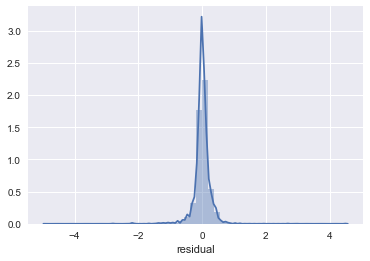

In [109]:
sns.distplot(res.resids)

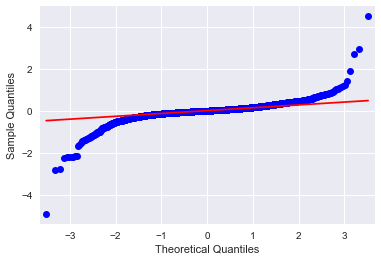

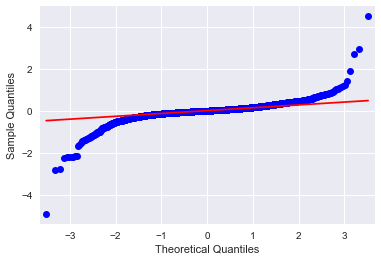

In [110]:
sm.graphics.qqplot(res.resids,line = 'q')

## Calculate FAC